## Limpieza de archivos BibTeX

In [1]:
import os
import hashlib
import tempfile
import shutil
import re
from pybtex.database.input import bibtex as bibtex_input
from pybtex.database.output import bibtex as bibtex_output
from pybtex.database import BibliographyData
from natsort import natsorted

def process_bibtex_file_with_clean_environment(file_path):
    """Procesa un archivo BibTeX con un entorno limpio para evitar problemas de caché."""
    # Crear directorio temporal
    temp_dir = tempfile.mkdtemp()
    try:
        # Copiar el archivo a un directorio temporal con un nombre único
        temp_file = os.path.join(temp_dir, f"temp_{os.path.basename(file_path)}")
        shutil.copy2(file_path, temp_file)
        
        # Usar un nuevo parser para cada archivo
        parser = bibtex_input.Parser()
        bib_data = parser.parse_file(temp_file)
        
        return bib_data
    finally:
        # Limpiar el directorio temporal
        shutil.rmtree(temp_dir)

def normalize_title(title):
    """Normaliza un título para facilitar la comparación.
    Elimina espacios extra, signos de puntuación y convierte a minúsculas."""
    if not title:
        return ""
    # Eliminar caracteres especiales y convertir a minúsculas
    normalized = re.sub(r'[^\w\s]', '', title.lower())
    # Eliminar espacios múltiples y convertir a minúsculas
    normalized = re.sub(r'\s+', ' ', normalized).strip().lower()
    return normalized

def merge_bibtex_files(file_paths, output_path, duplicates_path):
    merged_db = BibliographyData()
    duplicates_list = []
    processed_titles = {}  # Cambiado de processed_ids a processed_titles
    duplicate_entries = set()  # Para contar entradas duplicadas únicas

    for file_path in file_paths:
        try:
            print(f"\nProcesando: {file_path}")
            bib_data = process_bibtex_file_with_clean_environment(file_path)

            for entry_id, entry in bib_data.entries.items():
                # Verificar si el entry tiene un campo de título
                if 'title' not in entry.fields:
                    print(f"  Advertencia: Entrada {entry_id} sin título en {file_path}, se agregará como única")
                    merged_db.add_entry(entry_id, entry)
                    continue
                
                # Normalizar el título para comparación
                title = entry.fields['title']
                normalized_title = normalize_title(title)
                
                if normalized_title in processed_titles:
                    # Encontramos un título duplicado
                    original_entry_id, original_file = processed_titles[normalized_title]
                    print(f"  Duplicado encontrado por título: {title}")
                    print(f"  Original ID: {original_entry_id} en: {original_file}")
                    print(f"  Duplicado ID: {entry_id} en: {file_path}")
                    
                    # Agregar el ID a la lista de duplicados únicos
                    duplicate_entries.add(entry_id)

                    # Guardar duplicado como texto en la lista
                    duplicates_list.append(f"@{entry.type}{{{entry_id},\n")
                    duplicates_list.append(f"  title = {{{title}}},\n")
                    for field, value in entry.fields.items():
                        if field != 'title':  # Ya agregamos el título
                            duplicates_list.append(f"  {field} = {{{value}}},\n")
                    duplicates_list.append("}\n\n")
                    
                else:
                    # Es un título nuevo, lo agregamos
                    merged_db.add_entry(entry_id, entry)
                    processed_titles[normalized_title] = (entry_id, file_path)

        except Exception as e:
            print(f"Error al procesar {file_path}: {e}")

    # Guardar el archivo consolidado
    writer = bibtex_output.Writer()
    writer.write_file(merged_db, output_path)
    print(f"Archivo consolidado guardado en: {output_path}")

    # Guardar el archivo de duplicados manualmente
    if duplicates_list:
        with open(duplicates_path, "w", encoding="utf-8") as f:
            f.writelines(duplicates_list)
        print(f"Duplicados guardados en: {duplicates_path}")
    else:
        print("No se encontraron duplicados.")
    
    return len(merged_db.entries), len(duplicate_entries)

def main():
    folder_path = os.getenv("DOWNLOAD_PATH") 

    # Obtenemos los archivos .bib sin la ruta completa
    files_in_folder = [f for f in os.listdir(folder_path) if f.endswith('.bib')]
    
    # Ordenamos usando natsorted para lograr un "orden natural"
    files_in_folder = natsorted(files_in_folder)

    # Verificar en que orden se procesaran los archivos
    print("Orden de procesamiento de archivos:")
    for i, f in enumerate(files_in_folder):
        print(f"{i+1}. {f}")

    # Construimos las rutas completas
    bibtex_files = [os.path.join(folder_path, f) for f in files_in_folder]

    # Verificar que los archivos sean únicos
    print("\nVerificando unicidad de archivos...")
    file_hashes = {}
    unique_files = []
    
    for file_path in bibtex_files:
        # Calcular hash del archivo
        file_hash = hashlib.md5()
        with open(file_path, 'rb') as f:
            for chunk in iter(lambda: f.read(4096), b''):
                file_hash.update(chunk)
        
        # Verificar si ya hemos visto este hash
        digest = file_hash.hexdigest()
        if digest in file_hashes:
            print(f"¡ADVERTENCIA! Archivo duplicado detectado:")
            print(f"  - {file_path}")
            print(f"  - {file_hashes[digest]}")
            print(f"  Ambos tienen el mismo hash: {digest}")
        else:
            file_hashes[digest] = file_path
            unique_files.append(file_path)
    
    print(f"Total de archivos encontrados: {len(bibtex_files)}")
    print(f"Archivos únicos por contenido: {len(unique_files)}")
    
    # Proceder solo con archivos únicos
    bibtex_files = unique_files

    # Rutas para archivos de salida
    output_path = os.path.join( os.getenv("SALIDA_PATH") , "consolidado.bib")
    duplicates_path = os.path.join( os.getenv("DUPLICATE_PATH"), "duplicados.bib")
    
    unique_count, duplicate_count = merge_bibtex_files(bibtex_files, output_path, duplicates_path)
    
    print(f"\nResumen:")
    print(f"  Archivos procesados: {len(bibtex_files)}")
    print(f"  Entradas únicas: {unique_count}")
    print(f"  Entradas duplicadas: {duplicate_count}")

if __name__ == "__main__":
    main()

Orden de procesamiento de archivos:
1. IEEE Xplore Citation BibTeX Download 2025.9.24.22.54.21.bib
2. IEEE Xplore Citation BibTeX Download 2025.9.24.22.58.47.bib
3. IEEE Xplore Citation BibTeX Download 2025.9.24.23.0.57.bib
4. IEEE Xplore Citation BibTeX Download 2025.9.24.23.2.58.bib
5. IEEE Xplore Citation BibTeX Download 2025.9.24.23.17.14.bib
6. IEEE Xplore Citation BibTeX Download 2025.9.24.23.19.32.bib
7. IEEE Xplore Citation BibTeX Download 2025.9.24.23.32.17.bib
8. ScienceDirect_citations_1758816873794.bib
9. ScienceDirect_citations_1758816883390.bib
10. ieee_generative_ai_page_1.bib
11. ieee_generative_ai_page_2.bib
12. ieee_generative_ai_page_3.bib
13. ieee_generative_ai_page_4.bib
14. ieee_generative_ai_page_6.bib
15. ieee_generative_ai_page_7.bib
16. ieee_generative_ai_page_8.bib
17. ieee_generative_ai_page_9.bib
18. ieee_generative_ai_page_10.bib
19. ieee_generative_ai_page_13.bib
20. ieee_generative_ai_page_14.bib
21. ieee_generative_ai_page_15.bib
22. ieee_generative_ai_

## Aplicación de los Algoritmos

⚠️ TreeSort explotó en el campo year, lo marco como fallido.

📊 Resultados de ejecución:

   Campo           Algoritmo  Tamaño  Tiempo (s)
  author             timsort    9434    0.004811
  author            combsort    9434    0.076865
  author       selectionsort    9434    3.545249
  author            treesort    9434    0.000065
  author      pigeonholesort    9434    1.916270
  author          bucketsort    9434    0.009338
  author           quicksort    9434    0.155483
  author            heapsort    9434    0.013513
  author           gnomesort    9434   15.859721
  author binaryInsertionsort    9434    0.285381
  author           radixsort    9434    2.436513
   title             timsort    9434    0.007623
   title            combsort    9434    0.147530
   title       selectionsort    9434    4.795907
   title            treesort    9434    0.000301
   title      pigeonholesort    9434    1.411668
   title          bucketsort    9434    0.003990
   title           quicksort

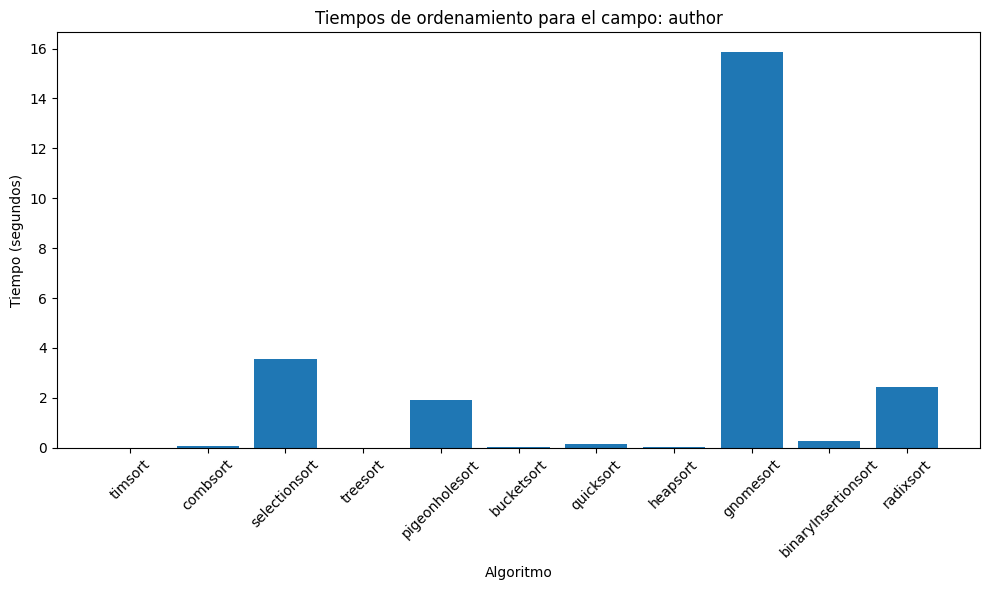

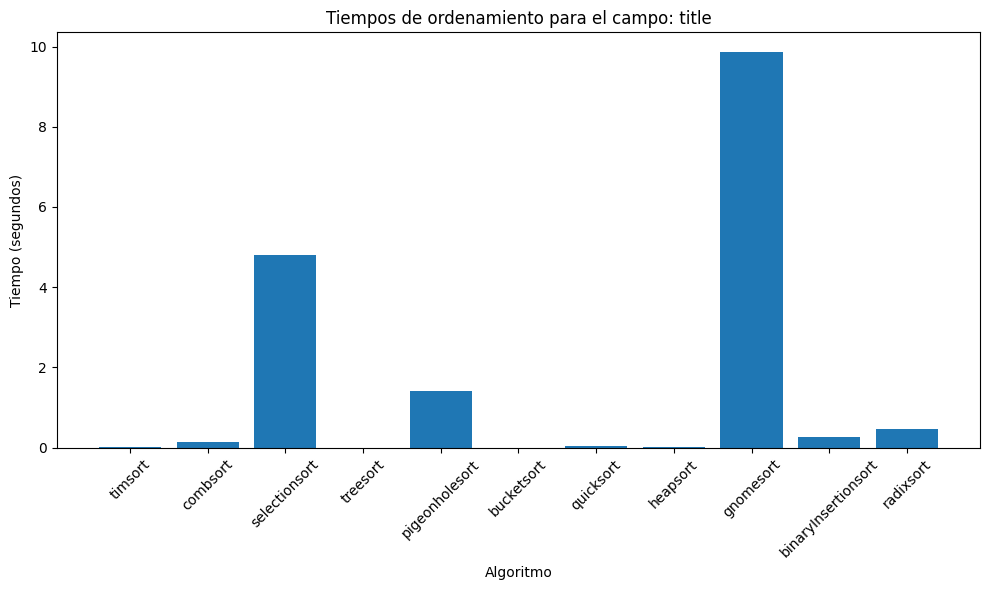

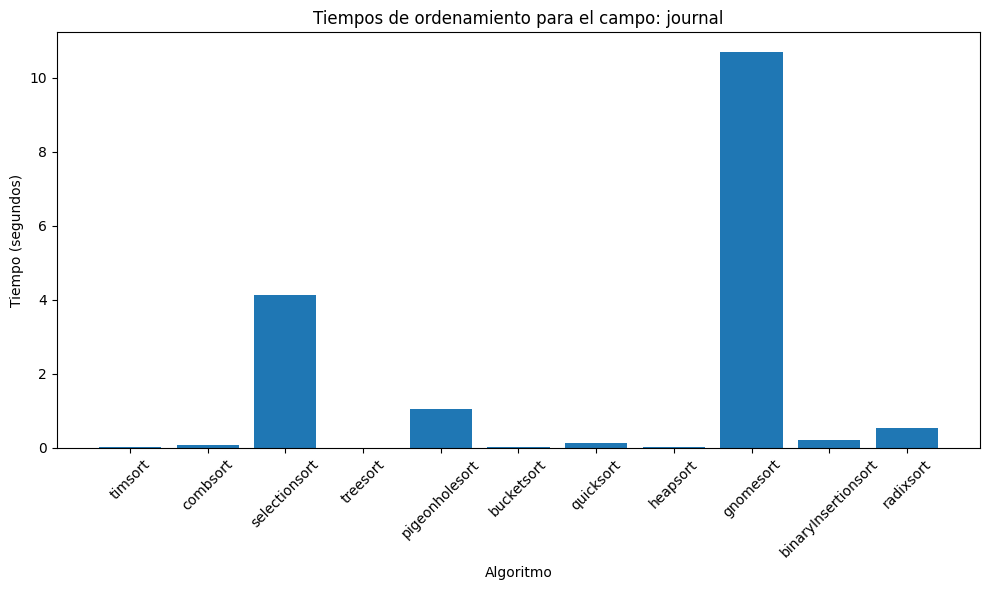

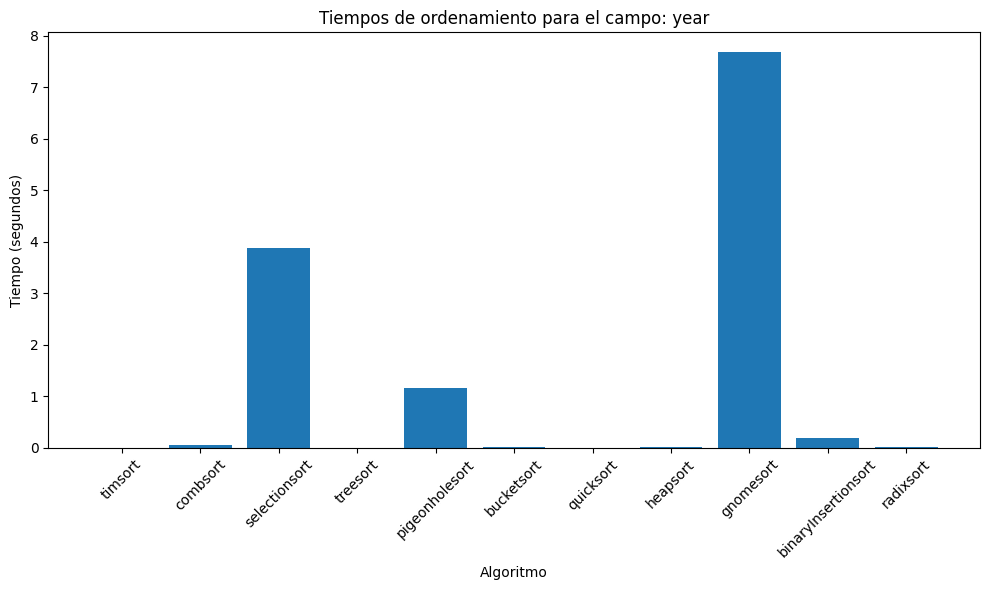

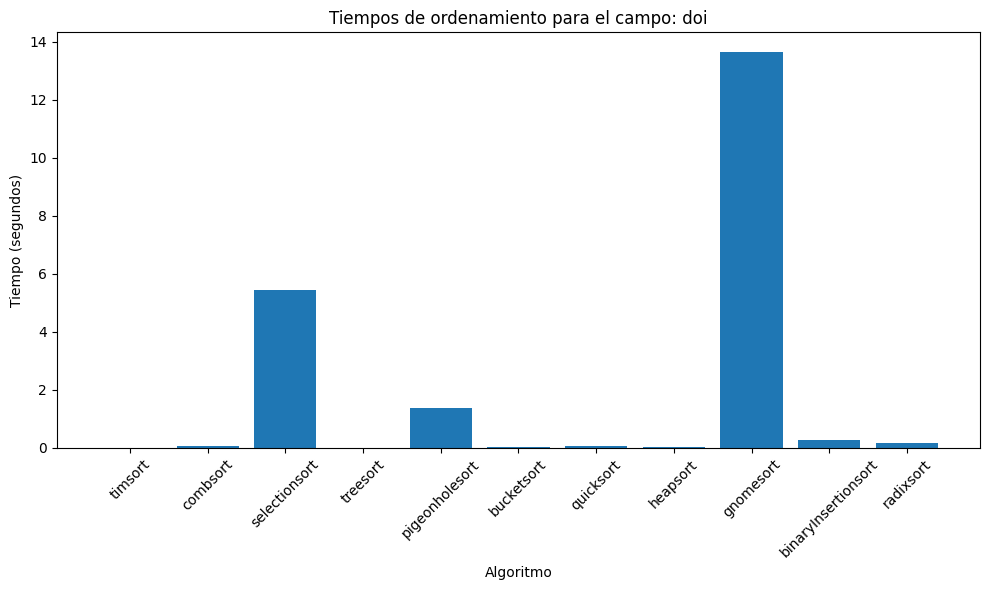

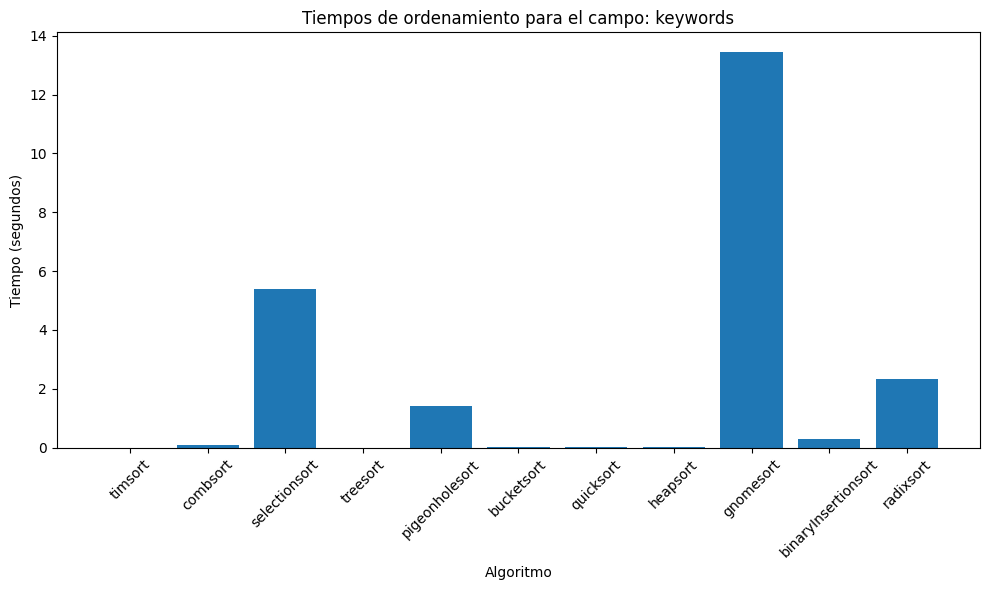

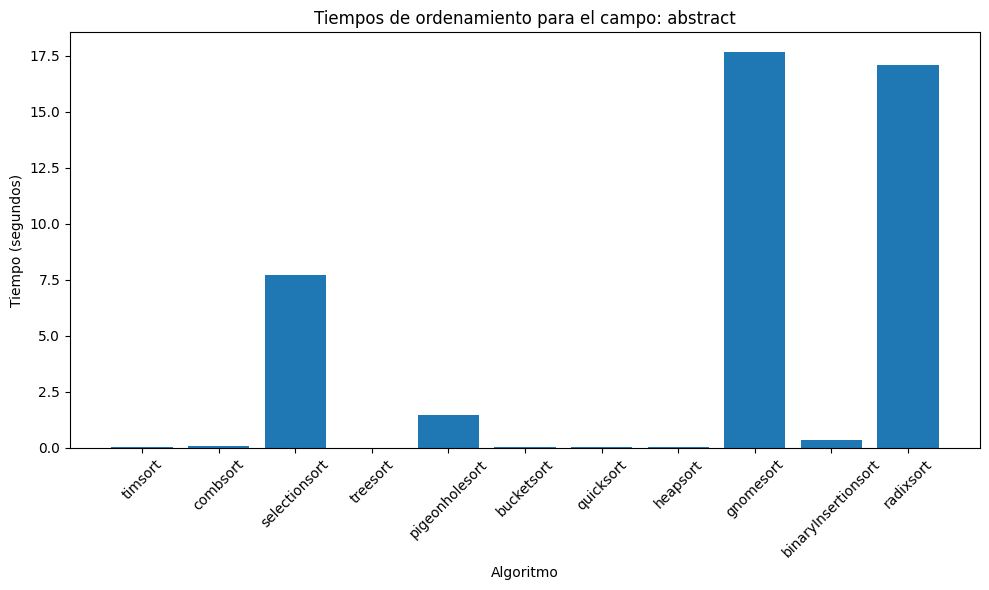

In [9]:
import os
import re
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import heapq
from functools import cmp_to_key
from collections import defaultdict
import math
import bisect

from dotenv import load_dotenv

# Cargar variables de entorno desde .env
load_dotenv()

# Definir rutas
BIBTEX_PATH =os.getenv("CONSOLIDADO_ORGANIZADO_PATH")
OUTPUT_PATH = os.getenv("ORDENAMIENTO_PATH")
TIMING_PATH = os.getenv("TIEMPOS_PATH")

# Crear directorios si no existen
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)
Path(TIMING_PATH).mkdir(parents=True, exist_ok=True)

# %%
def extract_bibtex_fields(file_path):
    """
    Extrae los campos de un archivo BibTeX.
    Se buscan las claves: author, title, journal, year, doi, keywords y abstract.
    Para journal se considera también booktitle.
    Si un campo no existe se asigna como cadena vacía.
    """
    fields = {
        'author': [],
        'title': [],
        'journal': [],
        'year': [],
        'doi': [],
        'keywords': [],
        'abstract': []
    }
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Buscar entradas BibTeX (cualquier tipo: article, inproceedings, etc.)
        entries = re.findall(r'@\w+\s*\{[^@]*\}', content, re.DOTALL)
        
        for entry in entries:
            for field in fields.keys():
                # Buscar el campo en la entrada, manejando {valor} o "valor"
                pattern = rf'{field}\s*=\s*[\{{\"](.*?)[\}}\"]'
                match = re.search(pattern, entry, re.IGNORECASE | re.DOTALL)
                
                # Para journal, buscar booktitle si no se encontró journal
                if field == 'journal' and not match:
                    pattern = r'booktitle\s*=\s*[\{{\"](.*?)[\}}\"]'
                    match = re.search(pattern, entry, re.IGNORECASE | re.DOTALL)
                
                if match:
                    value = match.group(1).strip()
                    fields[field].append(value)
                else:
                    fields[field].append("")
        
        return fields
        
    except Exception as e:
        print(f"Error al procesar el archivo BibTeX: {e}")
        return fields

# %%
# Implementación de Algoritmos de Ordenamiento

# 1. TimSort (usando sorted de Python, que es TimSort)
def timsort(arr):
    return sorted(arr)

# 2. Comb Sort
def combsort(arr):
    arr = arr.copy()
    n = len(arr)
    gap = n
    shrink = 1.3
    sorted_flag = False
    
    while not sorted_flag:
        gap = int(gap / shrink)
        if gap <= 1:
            gap = 1
            sorted_flag = True
        
        i = 0
        while i + gap < n:
            if arr[i] > arr[i + gap]:
                arr[i], arr[i + gap] = arr[i + gap], arr[i]
                sorted_flag = False
            i += 1
    
    return arr

# 3. Selection Sort
def selectionsort(arr):
    arr = arr.copy()
    n = len(arr)
    
    for i in range(n):
        min_idx = i
        for j in range(i+1, n):
            if arr[j] < arr[min_idx]:
                min_idx = j
        arr[i], arr[min_idx] = arr[min_idx], arr[i]
    
    return arr

# 4. Tree Sort
class Node:
    def __init__(self, key):
        self.key = key
        self.left = None
        self.right = None

def insert(root, key):
    if root is None:
        return Node(key)
    if key < root.key:
        root.left = insert(root.left, key)
    else:
        root.right = insert(root.right, key)
    return root

def in_order(root, result):
    if root:
        in_order(root.left, result)
        result.append(root.key)
        in_order(root.right, result)

def treesort(arr):
    if not arr:
        return []
    
    root = None
    for item in arr:
        root = insert(root, item)
    
    result = []
    in_order(root, result)
    return result

# 5. Pigeonhole Sort
def pigeonholesort(arr):
    if not arr:
        return []
    
    min_val = 0
    max_val = 0
    
    str_to_num = {}
    for i, s in enumerate(arr):
        if s == "":
            val = -1  # Manejar cadenas vacías
        else:
            val = hash(s) % 1000000  # Limitar el rango
        str_to_num[s] = val
        
        if i == 0 or val < min_val:
            min_val = val
        if i == 0 or val > max_val:
            max_val = val
    
    size = max_val - min_val + 1
    holes = [[] for _ in range(size)]
    
    for s in arr:
        val = str_to_num[s]
        holes[val - min_val].append(s)
    
    result = []
    for hole in holes:
        result.extend(sorted(hole))
    
    return result

# 6. Bucket Sort
def bucketsort(arr):
    if not arr:
        return []
    
    buckets = defaultdict(list)
    
    for s in arr:
        key = s[0].lower() if s != "" else ""
        buckets[key].append(s)
    
    result = []
    for key in sorted(buckets.keys()):
        result.extend(sorted(buckets[key]))
    
    return result

# 7. Quick Sort
def quicksort(arr):
    arr = arr.copy()
    
    def _quicksort(arr, low, high):
        if low < high:
            pi = partition(arr, low, high)
            _quicksort(arr, low, pi - 1)
            _quicksort(arr, pi + 1, high)
    
    def partition(arr, low, high):
        pivot = arr[high]
        i = low - 1
        
        for j in range(low, high):
            if arr[j] <= pivot:
                i += 1
                arr[i], arr[j] = arr[j], arr[i]
        arr[i + 1], arr[high] = arr[high], arr[i + 1]
        return i + 1
    
    _quicksort(arr, 0, len(arr) - 1)
    return arr

# 8. Heap Sort
def heapsort(arr):
    heap = arr.copy()
    heapq.heapify(heap)
    result = []
    while heap:
        result.append(heapq.heappop(heap))
    return result

# 9. Gnome Sort
def gnomesort(arr):
    arr = arr.copy()
    n = len(arr)
    pos = 0
    
    while pos < n:
        if pos == 0 or arr[pos] >= arr[pos - 1]:
            pos += 1
        else:
            arr[pos], arr[pos - 1] = arr[pos - 1], arr[pos]
            pos -= 1
    
    return arr

# 10. Binary Insertion Sort
def binaryInsertionsort(arr):
    arr = arr.copy()
    for i in range(1, len(arr)):
        key = arr[i]
        lo, hi = 0, i
        while lo < hi:
            mid = (lo + hi) // 2
            if arr[mid] <= key:
                lo = mid + 1
            else:
                hi = mid
        arr.insert(lo, arr.pop(i))
    return arr

# 11. Radix Sort para strings (LSD)
def radixsort(arr):
    if not arr:
        return []
    # Encontrar la longitud máxima de las cadenas
    max_len = max(len(s) for s in arr)
    # Procesar desde el último carácter hasta el primero
    for pos in range(max_len - 1, -1, -1):
        buckets = {}
        for s in arr:
            # Si la cadena es muy corta, usamos "" (que se ordena antes)
            key = s[pos] if pos < len(s) else ""
            buckets.setdefault(key, []).append(s)
        sorted_keys = sorted(buckets.keys())
        arr = []
        for key in sorted_keys:
            arr.extend(buckets[key])
    return arr

# %%
# Diccionario de algoritmos a utilizar
algorithms = {
    'timsort': timsort,
    'combsort': combsort,
    'selectionsort': selectionsort,
    'treesort': treesort,
    'pigeonholesort': pigeonholesort,
    'bucketsort': bucketsort,
    'quicksort': quicksort,
    'heapsort': heapsort,
    'gnomesort': gnomesort,
    'binaryInsertionsort': binaryInsertionsort,
    'radixsort': radixsort
}

# %%
# Extraer campos del archivo BibTeX
fields = extract_bibtex_fields(BIBTEX_PATH)

# Diccionarios para almacenar resultados ordenados y tiempos
sorted_results = { key: {} for key in fields.keys() }
timings = { key: {} for key in fields.keys() }

# Para cada campo, aplicar cada algoritmo y medir el tiempo de ejecución
import random

# Para cada campo, aplicar cada algoritmo y medir el tiempo de ejecución
for field, values in fields.items():
    for algo_name, algo_func in algorithms.items():
        # ⚡ limitar TreeSort
        if algo_name == "treesort":
            sample_values = random.sample(values, min(50, len(values)))  # 50 aleatorios
        else:
            sample_values = values

        try:
            start_time = time.time()
            sorted_list = algo_func(sample_values)
            end_time = time.time()
            elapsed = (end_time - start_time)
            
            sorted_results[field][algo_name] = sorted_list
            timings[field][algo_name] = elapsed
        except RecursionError:
            print(f"⚠️ TreeSort explotó en el campo {field}, lo marco como fallido.")
            sorted_results[field][algo_name] = []
            timings[field][algo_name] = float("nan")

# %%
# Escribir archivos de salida para cada clave en OUTPUT_PATH
for field, algo_results in sorted_results.items():
    file_path = os.path.join(OUTPUT_PATH, f"{field}.txt")
    with open(file_path, 'w', encoding='utf-8') as f:
        for algo_name in algorithms.keys():
            f.write(f"# ordenamiento por {algo_name}\n")
            for item in algo_results[algo_name]:
                f.write(item + "\n")
            f.write("\n")

# %%
# Escribir archivo con tiempos de ordenamiento en TIMING_PATH
timing_file = os.path.join(TIMING_PATH, "tiempo-ordenamiento.txt")
with open(timing_file, 'w', encoding='utf-8') as f:
    f.write("Campo,Algoritmo,Tiempo (segundos)\n")
    for field, algo_times in timings.items():
        for algo_name, t in algo_times.items():
            f.write(f"{field},{algo_name},{t}\n")

# %% 
# Crear tabla con tamaño y tiempo de cada algoritmo por campo
resultados_tabla = []

for field, algo_times in timings.items():
    tamaño = len(fields[field])  # número de elementos de ese campo
    for algo_name, t in algo_times.items():
        resultados_tabla.append({
            "Campo": field,
            "Algoritmo": algo_name,
            "Tamaño": tamaño,
            "Tiempo (s)": round(t, 6)
        })

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados_tabla)

# Mostrar tabla en pantalla
print("\n📊 Resultados de ejecución:\n")
print(df_resultados.to_string(index=False))

# Exportar a CSV y Markdown
csv_path = os.path.join(TIMING_PATH, "tabla_resultados.csv")
md_path = os.path.join(TIMING_PATH, "tabla_resultados.md")

df_resultados.to_csv(csv_path, index=False)

with open(md_path, "w", encoding="utf-8") as f:
    f.write(df_resultados.to_markdown(index=False))

print(f"\n✅ Tablas exportadas a:\n- {csv_path}\n- {md_path}")


# %%
# Graficar tiempos de ordenamiento para cada clave
for field, algo_times in timings.items():
    algo_names = list(algo_times.keys())
    times_list = [algo_times[algo] for algo in algo_names]
    
    plt.figure(figsize=(10,6))
    plt.bar(algo_names, times_list)
    plt.xlabel('Algoritmo')
    plt.ylabel('Tiempo (segundos)')
    plt.title(f'Tiempos de ordenamiento para el campo: {field}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Guardar la gráfica en TIMING_PATH (por ejemplo, "tiempo_author.png")
    plt.savefig(os.path.join(TIMING_PATH, f"tiempo_{field}.png"))
    plt.show()

## Top 15 Autores mas repetidos

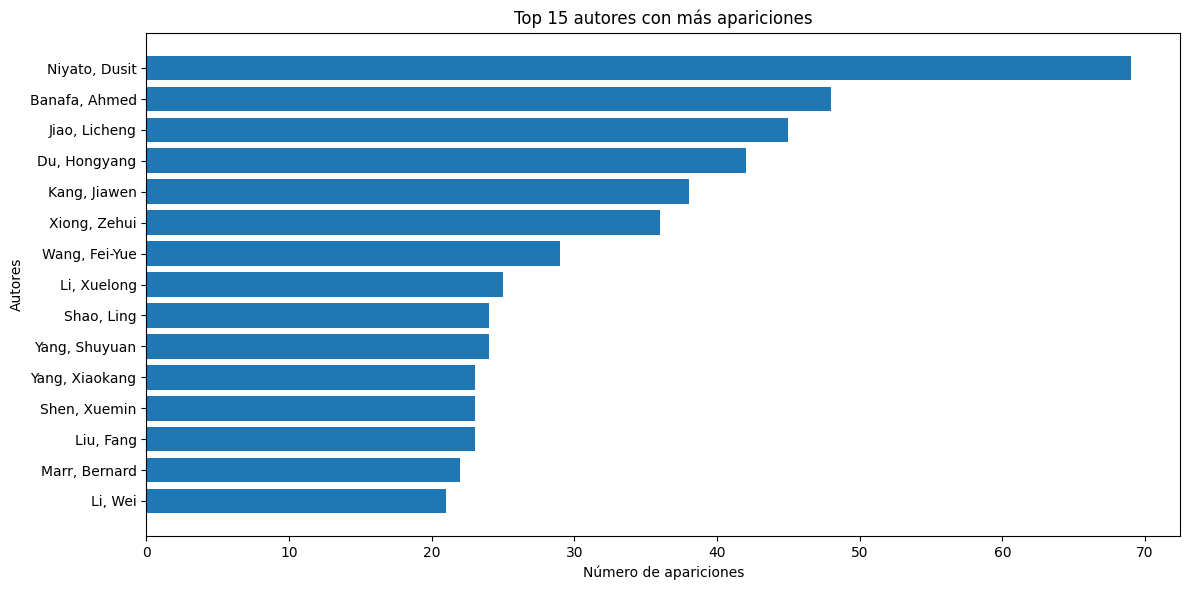

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import re

# %% Extraer campos del archivo BibTeX
fields = extract_bibtex_fields(BIBTEX_PATH)

# Separar autores (si vienen en formato "Autor1 and Autor2")
all_authors = []
for entry in fields['author']:
    autores = re.split(r'\s+and\s+', entry, flags=re.IGNORECASE)
    all_authors.extend([a.strip() for a in autores if a.strip() != ""])

# Contar ocurrencias
contador = Counter(all_authors)
top15 = contador.most_common(15)  # ya viene ordenado de mayor a menor

# Para gráfica, invertimos para que el mayor quede arriba en barh
autores, conteos = zip(*reversed(top15))

plt.figure(figsize=(12,6))
plt.barh(autores, conteos)  # gráfica horizontal
plt.xlabel("Número de apariciones")
plt.ylabel("Autores")
plt.title("Top 15 autores con más apariciones")
plt.tight_layout()
plt.show()
